## **README**
  
[GVAE] H. Hosoya, “Group-based Learning of Disentangled Representations with Generalizability for Novel Contents,” in Proceedings of the Twenty-Eighth International Joint Conference on Artificial Intelligence, Macao, China, 2019, pp. 2506–2513, doi: 10.24963/ijcai.2019/348.

 
[MLVAE] D. Bouchacourt, R. Tomioka, and S. Nowozin, “Multi-Level Variational Autoencoder: Learning Disentangled Representations from Grouped Observations,” arXiv:1705.08841 [cs, stat], May 2017, Accessed: Feb. 19, 2021. [Online]. Available: http://arxiv.org/abs/1705.08841.
  

In [1]:
# -*- coding: utf-8 -*-
from IPython import display

import os, sys, time, glob, io, pprint, re, shutil
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import h5py
import pandas as pd
from datetime import datetime

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
tfkltd = tf.keras.layers.TimeDistributed
from tensorflow.keras.utils import to_categorical

from absl import app, flags

if not sys.version_info[0]==3:
    sys.exit("Python 3 required")

""" specify available GPUs """
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4,5"

""" limit GPU memory growth """
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # currently memory growth needs to be same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs\n\n")
    except RuntimeError as e:
        # memory growth must be set before GPUs have been initialized
        print(e)
        
""" clear tensorflow session """
tfk.backend.clear_session()


2 Physical GPUs 2 Logical GPUs




In [2]:
strategy = tf.distribute.MirroredStrategy()
print('num devices = %d'%strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
num devices = 2


### Bag MNIST data into instances

In [3]:
NUM_INSTANCES = 21 # number of instances in a bag
NUM_CLASS = 10     # mnist has 10 classes

(trn_images, trn_labels), (tst_images, tst_labels) = tfk.datasets.mnist.load_data()

def rescale_and_flatten_images(images):
    images = images.reshape((images.shape[0], 28*28)) / 255.
    return images.astype('float32')
#     return np.where(images > .5, 1.0, 0.0).astype('float32')

trn_images = rescale_and_flatten_images(trn_images)
tst_images = rescale_and_flatten_images(tst_images)

print(trn_images.shape)
print(tst_images.shape)

(60000, 784)
(10000, 784)


In [4]:
BUFFER_SIZE = trn_images.shape[0]
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

NUM_TRAIN=trn_images.shape[0]
MASK_SIZE=10

class MaskedMNISTDataset(tf.data.Dataset):
    def _generator():
        """ Yields a single datapoint which consists of the tuple

            data_replicate = (R[0]data, ..., R[nreplicate]data)
            shifts = 
        """
        for ii in range(NUM_TRAIN):
            img = trn_images[ii,:] # [data_dim]
            img = np.expand_dims(img, axis=0) #[1, data_dim]
            img_instances = np.repeat(img, NUM_INSTANCES, axis=0) #[instances, data_dim]
            
            for kk in range(NUM_INSTANCES):
                tmp = img_instances[kk,:].reshape(28,28)

                mask = np.ones((28,28))
                xx = np.random.randint(28-MASK_SIZE)
                yy = np.random.randint(28-MASK_SIZE)
                
                tmp[xx:(xx+MASK_SIZE), yy:(yy+MASK_SIZE)] = 1.
                img_instances[kk,:] = tmp.flatten()
            
            bagged_masked_img = img_instances
            
#             mask_instances = np.zeros(img_instances.shape)
#             for kk in range(NUM_INSTANCES):
#                 mask = np.ones((28,28))
#                 xx = np.random.randint(28-MASK_SIZE)
#                 yy = np.random.randint(28-MASK_SIZE)
                
#                 mask[xx:(xx+MASK_SIZE), yy:(yy+MASK_SIZE)] = 0.
#                 mask_instances[kk,:] = mask.flatten()
            
#             bagged_masked_img = img_instances*mask_instances
            
            yield bagged_masked_img.astype('float32')
               
    def __new__(self):
        return tf.data.Dataset.from_generator(
            self._generator,
            output_types = (tf.float32),
            output_shapes = (tf.TensorShape([NUM_INSTANCES, 28*28])),            
        )
    
trn_dataset = MaskedMNISTDataset().prefetch(tf.data.experimental.AUTOTUNE)
trn_dataset = trn_dataset.shuffle(NUM_TRAIN)
trn_dataset = trn_dataset.batch(GLOBAL_BATCH_SIZE)

# distributed dataset
trn_dist_dataset = strategy.experimental_distribute_dataset(trn_dataset)

### Define GVAE Model

In [5]:
""" Custom Layers """
class StyleEncoder(tfkl.Layer):
    """ Responsible for encoding the style of each instance.
    
    Maps [?, instances, data_dim] -> [?, instances, sty_dim] (for mean and log-variance)
    """
    def __init__(self, style_dim, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        """ define dimensions """
        self.style_dim = style_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(style_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(style_dim)
                    ],
                    name="z_mean",
                )

        self.enc_log_var = tfk.Sequential(
                [   tfkl.Dense(style_dim, activation=tf.math.softplus)
                    ],
                    name="z_log_var",
                )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, style_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, style_dim]
        z_log_var = self.enc_log_var(common) # [?*instances, style_dim]
        
        # reshape back to [?, instances, style_dim]
        z_mean = tfkl.Reshape((ninstances, self.style_dim))(z_mean)
        z_log_var = tfkl.Reshape((ninstances, self.style_dim))(z_log_var)
        
        return z_mean, z_log_var
    
class ContentEncoder(tfkl.Layer):
    """ Responsible for encoding the content common to each instance.
    
    For GVAE the content encoder N(z|x1,...xk) has the parametric form
    of N( \avg \mu(xi), \avg s(xi), i.e. averaging a common encoder across instances.
    
    Maps [?, instances, data_dim] -> [?, 1, content_dim] (for mean and log-variance)
    """
    def __init__(self, content_dim, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        """ define dimensions """
        self.content_dim = content_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(content_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(content_dim)
                    ],
                    name="z_mean",
                )

        self.enc_log_var = tfk.Sequential(
                [   tfkl.Dense(content_dim, activation=tf.math.softplus)
                    ],
                    name="z_log_var",
                )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, content_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, content_dim]
        z_log_var = self.enc_log_var(common) # [?*instances, content_dim]
        
        # reshape back to [?, instances, content_dim]
        z_mean = tfkl.Reshape((ninstances, self.content_dim))(z_mean)
        z_log_var = tfkl.Reshape((ninstances, self.content_dim))(z_log_var)
        
        # compute average to [?, content_dim]
        z_mean = tfkl.GlobalAveragePooling1D()(z_mean)
        z_log_var = tfkl.GlobalAveragePooling1D()(z_log_var)
        
        # [?, content_dim] -> [?, 1, content_dim]
        z_mean = tfkl.Reshape((1, self.content_dim))(z_mean)
        z_log_var = tfkl.Reshape((1, self.content_dim))(z_log_var)
        
        return z_mean, z_log_var

class Decoder(tfkl.Layer):
    """ Decodes each pair of (z_content, z_instance)
    
    The number of instances is automatically inferred at runtime.
    
    Maps [?, instances, latent_dim] -> [?, instances, data_dim]
    """
    def __init__(self, data_dim, dec_var_model='trainable',
            name='decoder', **kwargs):
        super().__init__(name, **kwargs)
        
        self.data_dim = data_dim
        
        self.dec_var_model = dec_var_model

#         trainable = True if dec_var_model=='trainable' else False
        self.dec_var = tf.Variable(
                initial_value= tf.constant(1.0, dtype='float32'),
                name='dec_var',
                trainable= True if dec_var_model=='trainable' else False,
#                 trainable=trainable,
                )
        
        self.dec_per_instance = tfk.Sequential(
            [   tfkl.Dense(256),
                tfkl.LeakyReLU(),
                tfkl.Dense(512),
                tfkl.LeakyReLU(),
                tfkl.Dense(data_dim, activation='sigmoid'),
            ],
            name="dec_per_instance",        
        )

    def call(self, z):
        # infer number of instances [?, instances, latent_dim]
        ninstances = z.shape[1]
        latent_dim = z.shape[2]
        
        # reshape instances to sample axis : [?*instances, latent_dim]
        z = tfkl.Reshape((-1, latent_dim))(z)
        # apply decoding to each instance : [?*instances, data_dim]
        x_mean = self.dec_per_instance(z)
        # collect instances : [?, instances, data_dim]
        x_mean = tfkl.Reshape((ninstances, self.data_dim))(x_mean)
        
        x_var = self.dec_var

        return x_mean, x_var
    
class Sampler(tfkl.Layer):
    """ Samples from Normal with z_mean and z_log_var.

    Returns  (-1, z_mean.shape[0], nsamp)
    """
    def __init__(self, nsamp=1, name='sampler', **kwargs):
        super().__init__(name=name, **kwargs)

        if nsamp > 1:
            raise NotImplementedError

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tfk.backend.random_normal(shape=tf.shape(z_mean))

        return z_mean + 0.5*tf.exp(z_log_var)*epsilon

class GVAE(tfk.Model):
    """ Grouped Variational Auto-Encoder
    
    [Input]
        X ~ [?, instances, data_dim]
    """
    def __init__(self, data_dim, style_dim, content_dim,
            nsamp=1, name='GVAE', dec_var_model ='trainable', **kwargs):
        """ initialize """
        super().__init__(name=name, **kwargs)
        
        self.dec_var_model = dec_var_model

        """ define dimensions """
        self.data_dim = data_dim
        self.style_dim = style_dim
        self.content_dim = content_dim
        latent_dim = style_dim + content_dim
        self.latent_dim = style_dim + content_dim
                        
        """ build encoder & decoder graphs """
        self.style_encoder = StyleEncoder(style_dim)
        self.content_encoder = ContentEncoder(content_dim)
        self.decoder = Decoder(data_dim, dec_var_model=dec_var_model)
        
        self.sampler = Sampler()

    def call(self, inputs):
        # input = [?, instances, data_dim]
        X = inputs
        ninstances = X.shape[1]
        
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean, sty_log_var = self.style_encoder(X)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
        cnt_log_var_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_log_var)
        
        # sample
        z_sty = self.sampler( (sty_mean, sty_log_var) ) # [?, instances, style_dim]
        z_cnt = self.sampler( (cnt_mean_replicate, cnt_log_var_replicate) ) # [?, instances, content_dim]
        
        # concatenate
        z = tfkl.Concatenate(axis=-1)([z_sty, z_cnt])
               
        # decode
        dec_mean, dec_var = self.decoder(z)

        """ compute ELBO loss """
        
        # squared error per example
        se = tf.square(X - dec_mean) # [?, instances, data_dim]
        se_per_instance = tf.reduce_sum(se, axis=-1) # [?, instances]
        se_per_ex = tf.reduce_sum(se_per_instance, axis=-1) #[?, ]
        
        log_llhd_per_ex = (1/dec_var)*se_per_ex + ninstances*tf.math.log(dec_var)
        log_llhd_per_ex = -0.5*log_llhd_per_ex # [?,], we 'max' the ELBO        
        
        sty_KL = -sty_log_var + tf.exp(sty_log_var) + tf.square(sty_mean) # [?, instances, style_dim]
        sty_KL_per_instance = tf.reduce_sum(sty_KL, axis=-1) # [?, instances]
        sty_KL_per_ex = 0.5*tf.reduce_sum(sty_KL_per_instance, axis=-1) # [?, ]
        
        cnt_mean = cnt_mean[:,0,:] #[?, 1, content_dim] -> [?, content_dim]
        cnt_log_var = cnt_log_var[:,0,:] #[?, 1, content_dim] -> [?, content_dim]
        cnt_KL = -cnt_log_var + tf.exp(cnt_log_var) + tf.square(cnt_mean) #[?, content_dim]
        cnt_KL_per_ex = 0.5*tf.reduce_sum(cnt_KL, axis=-1) #[?, ]
        
        ELBO_per_ex = log_llhd_per_ex - sty_KL_per_ex - cnt_KL_per_ex # [?, ]
        
        return ELBO_per_ex, log_llhd_per_ex, sty_KL_per_ex, cnt_KL_per_ex, se_per_ex, dec_mean

    def encode_decode(self, inputs):
        """ Apply VAE deterministically: xhat = dec(enc(x))
        """
        X = inputs
                
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean, sty_log_var = self.style_encoder(X)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
   
        # concatenate
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode
        dec_mean, dec_var = self.decoder(z)

        return dec_mean

    def content_encode(self, X):        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        return cnt_mean
    
    def style_encode(self, X):         
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean, sty_log_var = self.style_encoder(X)
        return sty_mean
    
    def style_decode(self, cnt_mean, sty_mean):
        ninstances = sty_mean.shape[1]
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances)(cnt_mean)
   
        # concatenate:  [?, instances, latent_dim]
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode: [?, instances, data_dim]
        dec_mean, _ = self.decoder(z)
        
        return dec_mean

    def decode(self, z):
        """ Apply decoder to arbitrary input """
        x_dec, x_var = self.decoder(z)

        return x_dec, x_var

### Optimization

In [6]:
with strategy.scope():
    # define model
    style_dim = 20
    content_dim = 20
    data_dim = 28*28
    ninstances = NUM_INSTANCES
    
    gvae = GVAE(data_dim, style_dim, content_dim, dec_var_model='fixed')
    
    # setup exponential schedular
    initial_learning_rate = 2e-4
#     initial_learning_rate = 1e-3
    lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps=2000,
                decay_rate=0.96,
                staircase=True)

    # opt = tf.optimizers.Adam(learning_rate=5e-4)
    opt = tf.optimizers.Adam(learning_rate=lr_schedule)
    
    # instantiante model again inside strategy scope   
    trn_loss_metric = tfk.metrics.Mean()
    trn_mse_metric = tfk.metrics.Mean()
    trn_sty_KL_metric = tfk.metrics.Mean()
    trn_cnt_KL_metric = tfk.metrics.Mean()

@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # call model: returns losses per each example, i.e. shape [?,]
        elbo_per_ex, log_llhd_per_ex, sty_KL_per_ex, cnt_KL_per_ex, mse_per_ex, x_mean = gvae(inputs)

        # compute average loss using batch size
        elbo = tf.nn.compute_average_loss(elbo_per_ex, global_batch_size=GLOBAL_BATCH_SIZE)
        loss = -elbo
        
    # track metrics
    trn_loss_metric(-elbo_per_ex)
    trn_mse_metric(mse_per_ex)
    trn_sty_KL_metric(sty_KL_per_ex)
    trn_cnt_KL_metric(cnt_KL_per_ex)
    
    # apply gradients
    grads = tape.gradient(loss, gvae.trainable_weights)
    opt.apply_gradients(zip(grads, gvae.trainable_weights))
    
    return loss

# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return 


Start of epoch 0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INF

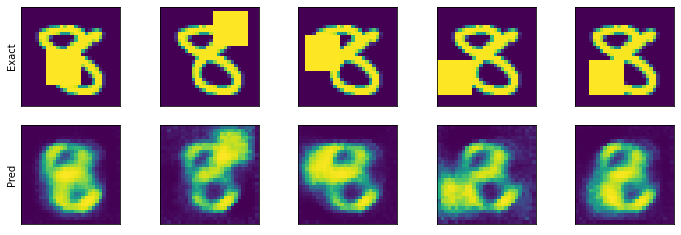

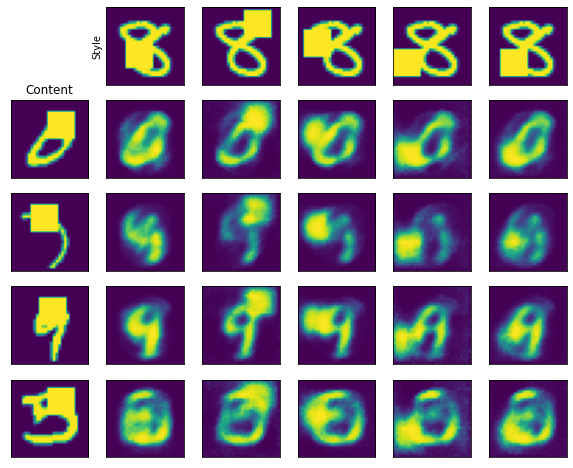

	mean loss    = 898.918
	mse          = 1.205e+03
	KL           = 2.683e+02
	KL           = 2.800e+01
	dec_var      = 1.000e+00
epoch = 58.57s
Start of epoch 1
	mean loss    = 675.185
	mse          = 7.279e+02
	KL           = 2.846e+02
	KL           = 2.662e+01
	dec_var      = 1.000e+00
epoch = 45.88s
Start of epoch 2
	mean loss    = 636.059
	mse          = 6.428e+02
	KL           = 2.857e+02
	KL           = 2.894e+01
	dec_var      = 1.000e+00
epoch = 45.53s
Start of epoch 3
	mean loss    = 614.498
	mse          = 5.940e+02
	KL           = 2.872e+02
	KL           = 3.024e+01
	dec_var      = 1.000e+00
epoch = 45.33s
Start of epoch 4
	mean loss    = 598.606
	mse          = 5.574e+02
	KL           = 2.888e+02
	KL           = 3.111e+01
	dec_var      = 1.000e+00
epoch = 44.74s
Start of epoch 5
=== TRN ===


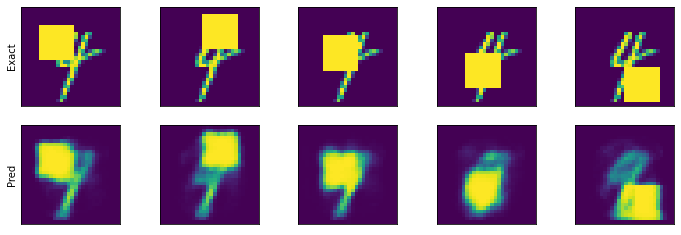

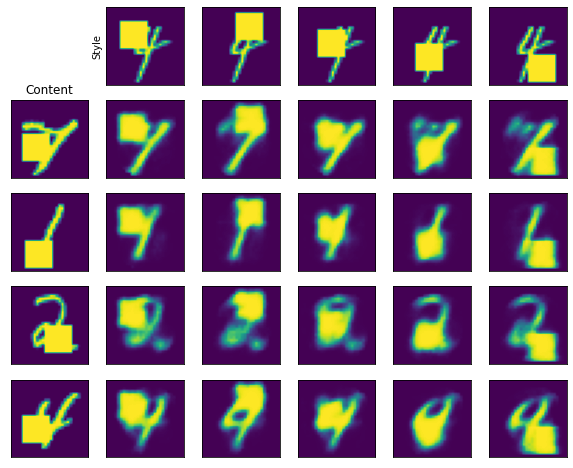

	mean loss    = 587.020
	mse          = 5.307e+02
	KL           = 2.899e+02
	KL           = 3.171e+01
	dec_var      = 1.000e+00
epoch = 46.48s
Start of epoch 6
	mean loss    = 577.447
	mse          = 5.089e+02
	KL           = 2.909e+02
	KL           = 3.213e+01
	dec_var      = 1.000e+00
epoch = 45.00s
Start of epoch 7
	mean loss    = 569.399
	mse          = 4.909e+02
	KL           = 2.915e+02
	KL           = 3.245e+01
	dec_var      = 1.000e+00
epoch = 45.05s
Start of epoch 8
	mean loss    = 562.409
	mse          = 4.753e+02
	KL           = 2.920e+02
	KL           = 3.275e+01
	dec_var      = 1.000e+00
epoch = 45.58s
Start of epoch 9
	mean loss    = 556.280
	mse          = 4.617e+02
	KL           = 2.925e+02
	KL           = 3.300e+01
	dec_var      = 1.000e+00
epoch = 45.20s
Start of epoch 10
=== TRN ===


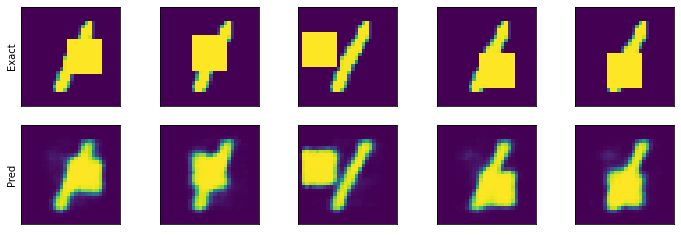

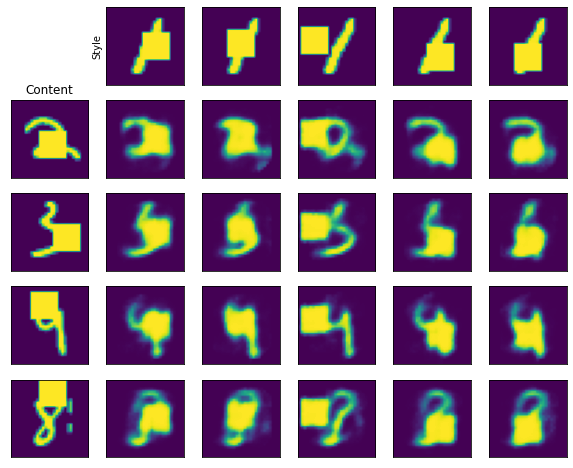

	mean loss    = 550.110
	mse          = 4.481e+02
	KL           = 2.927e+02
	KL           = 3.333e+01
	dec_var      = 1.000e+00
epoch = 47.29s
Start of epoch 11
	mean loss    = 545.140
	mse          = 4.372e+02
	KL           = 2.930e+02
	KL           = 3.357e+01
	dec_var      = 1.000e+00
epoch = 46.21s
Start of epoch 12
	mean loss    = 540.925
	mse          = 4.281e+02
	KL           = 2.931e+02
	KL           = 3.376e+01
	dec_var      = 1.000e+00
epoch = 45.51s
Start of epoch 13
	mean loss    = 537.296
	mse          = 4.201e+02
	KL           = 2.933e+02
	KL           = 3.392e+01
	dec_var      = 1.000e+00
epoch = 45.42s
Start of epoch 14
	mean loss    = 533.947
	mse          = 4.130e+02
	KL           = 2.934e+02
	KL           = 3.404e+01
	dec_var      = 1.000e+00
epoch = 46.17s
Start of epoch 15
=== TRN ===


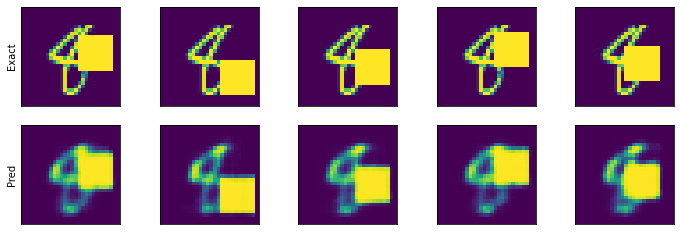

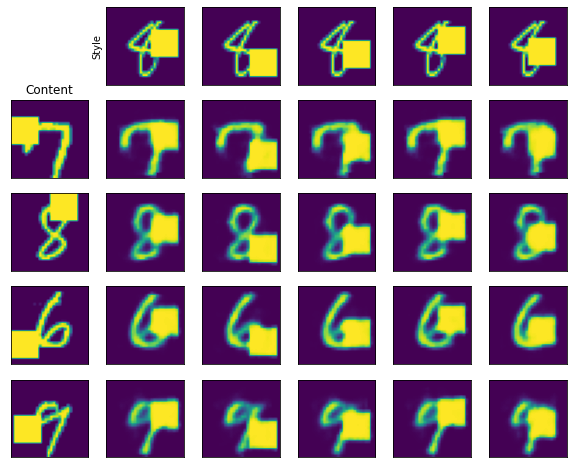

	mean loss    = 531.034
	mse          = 4.065e+02
	KL           = 2.936e+02
	KL           = 3.417e+01
	dec_var      = 1.000e+00
epoch = 47.46s
Start of epoch 16
	mean loss    = 528.573
	mse          = 4.011e+02
	KL           = 2.938e+02
	KL           = 3.429e+01
	dec_var      = 1.000e+00
epoch = 45.42s
Start of epoch 17
	mean loss    = 525.911
	mse          = 3.956e+02
	KL           = 2.937e+02
	KL           = 3.435e+01
	dec_var      = 1.000e+00
epoch = 46.00s
Start of epoch 18
	mean loss    = 523.839
	mse          = 3.910e+02
	KL           = 2.939e+02
	KL           = 3.445e+01
	dec_var      = 1.000e+00
epoch = 45.76s
Start of epoch 19
	mean loss    = 521.841
	mse          = 3.867e+02
	KL           = 2.940e+02
	KL           = 3.453e+01
	dec_var      = 1.000e+00
epoch = 45.94s
Start of epoch 20
=== TRN ===


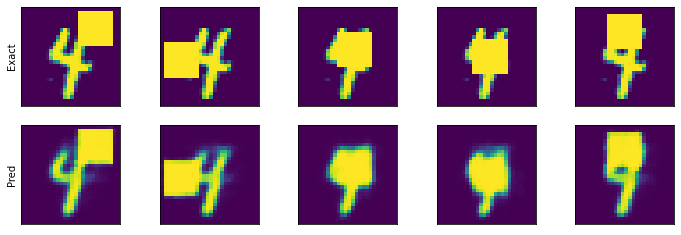

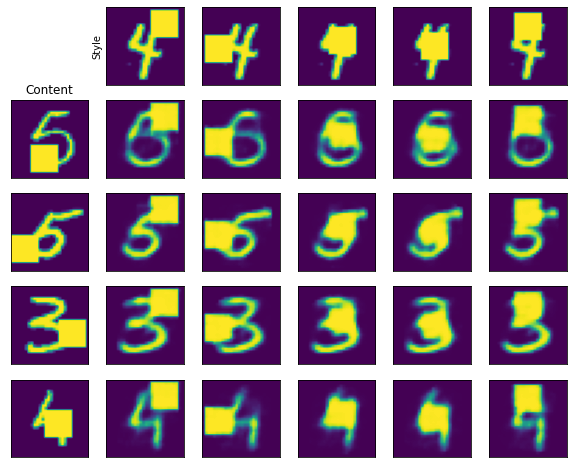

	mean loss    = 520.025
	mse          = 3.825e+02
	KL           = 2.941e+02
	KL           = 3.463e+01
	dec_var      = 1.000e+00
epoch = 46.62s
Start of epoch 21
	mean loss    = 518.227
	mse          = 3.788e+02
	KL           = 2.941e+02
	KL           = 3.472e+01
	dec_var      = 1.000e+00
epoch = 46.35s
Start of epoch 22
	mean loss    = 516.551
	mse          = 3.751e+02
	KL           = 2.942e+02
	KL           = 3.481e+01
	dec_var      = 1.000e+00
epoch = 45.92s
Start of epoch 23
	mean loss    = 514.751
	mse          = 3.710e+02
	KL           = 2.943e+02
	KL           = 3.494e+01
	dec_var      = 1.000e+00
epoch = 46.11s
Start of epoch 24
	mean loss    = 513.314
	mse          = 3.677e+02
	KL           = 2.944e+02
	KL           = 3.505e+01
	dec_var      = 1.000e+00
epoch = 45.65s
Start of epoch 25
=== TRN ===


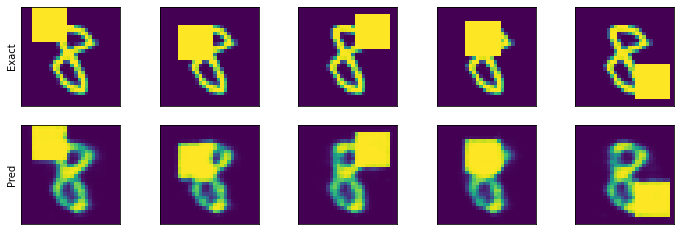

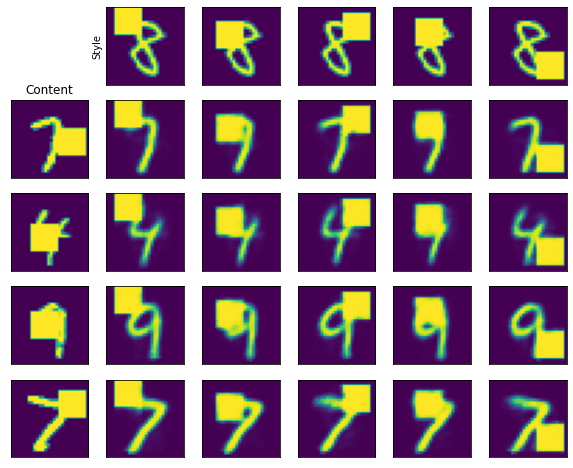

	mean loss    = 511.844
	mse          = 3.645e+02
	KL           = 2.945e+02
	KL           = 3.514e+01
	dec_var      = 1.000e+00
epoch = 47.41s
Start of epoch 26
	mean loss    = 510.589
	mse          = 3.617e+02
	KL           = 2.945e+02
	KL           = 3.524e+01
	dec_var      = 1.000e+00
epoch = 45.27s
Start of epoch 27
	mean loss    = 509.410
	mse          = 3.593e+02
	KL           = 2.945e+02
	KL           = 3.528e+01
	dec_var      = 1.000e+00
epoch = 45.28s
Start of epoch 28
	mean loss    = 508.299
	mse          = 3.567e+02
	KL           = 2.946e+02
	KL           = 3.534e+01
	dec_var      = 1.000e+00
epoch = 46.69s
Start of epoch 29
	mean loss    = 507.305
	mse          = 3.546e+02
	KL           = 2.946e+02
	KL           = 3.541e+01
	dec_var      = 1.000e+00
epoch = 45.14s
Start of epoch 30
=== TRN ===


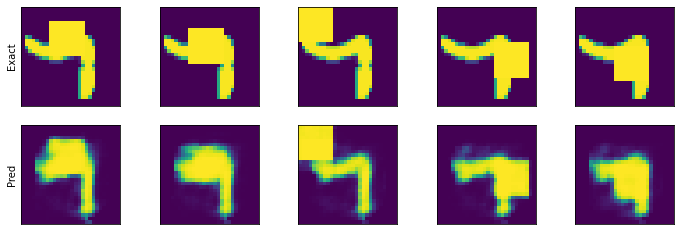

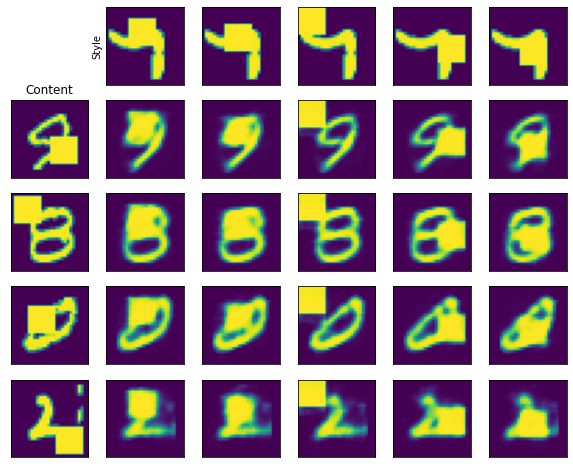

	mean loss    = 506.348
	mse          = 3.524e+02
	KL           = 2.947e+02
	KL           = 3.545e+01
	dec_var      = 1.000e+00
epoch = 47.15s
Start of epoch 31
	mean loss    = 505.383
	mse          = 3.503e+02
	KL           = 2.947e+02
	KL           = 3.549e+01
	dec_var      = 1.000e+00
epoch = 46.47s
Start of epoch 32
	mean loss    = 504.506
	mse          = 3.484e+02
	KL           = 2.947e+02
	KL           = 3.558e+01
	dec_var      = 1.000e+00
epoch = 44.82s
Start of epoch 33
	mean loss    = 503.506
	mse          = 3.463e+02
	KL           = 2.948e+02
	KL           = 3.560e+01
	dec_var      = 1.000e+00
epoch = 46.24s
Start of epoch 34
	mean loss    = 502.865
	mse          = 3.449e+02
	KL           = 2.948e+02
	KL           = 3.565e+01
	dec_var      = 1.000e+00
epoch = 45.36s
Start of epoch 35
=== TRN ===


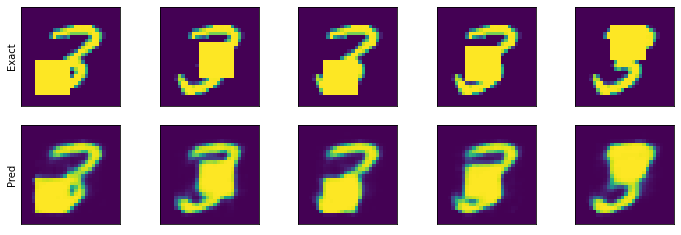

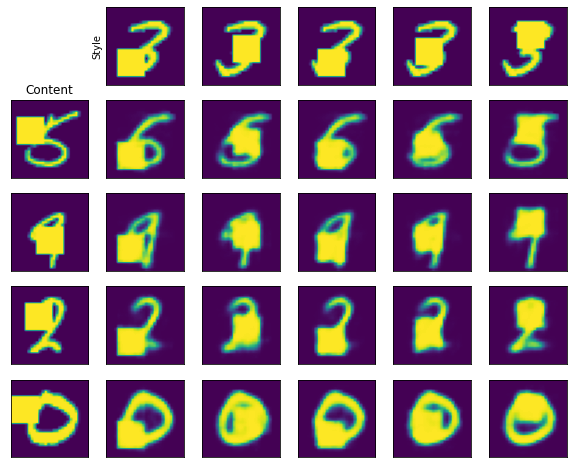

	mean loss    = 502.174
	mse          = 3.431e+02
	KL           = 2.949e+02
	KL           = 3.569e+01
	dec_var      = 1.000e+00
epoch = 47.54s
Start of epoch 36
	mean loss    = 501.448
	mse          = 3.416e+02
	KL           = 2.949e+02
	KL           = 3.571e+01
	dec_var      = 1.000e+00
epoch = 45.68s
Start of epoch 37
	mean loss    = 500.704
	mse          = 3.400e+02
	KL           = 2.949e+02
	KL           = 3.575e+01
	dec_var      = 1.000e+00
epoch = 45.75s
Start of epoch 38
	mean loss    = 500.206
	mse          = 3.388e+02
	KL           = 2.950e+02
	KL           = 3.578e+01
	dec_var      = 1.000e+00
epoch = 45.17s
Start of epoch 39
	mean loss    = 499.489
	mse          = 3.373e+02
	KL           = 2.950e+02
	KL           = 3.581e+01
	dec_var      = 1.000e+00
epoch = 45.66s
Start of epoch 40
=== TRN ===


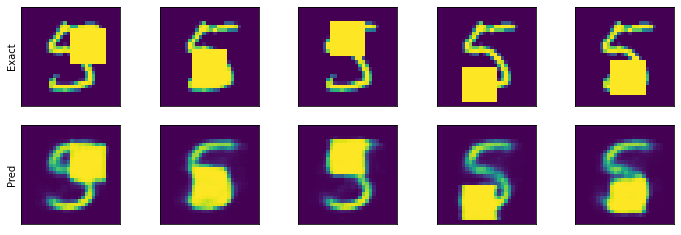

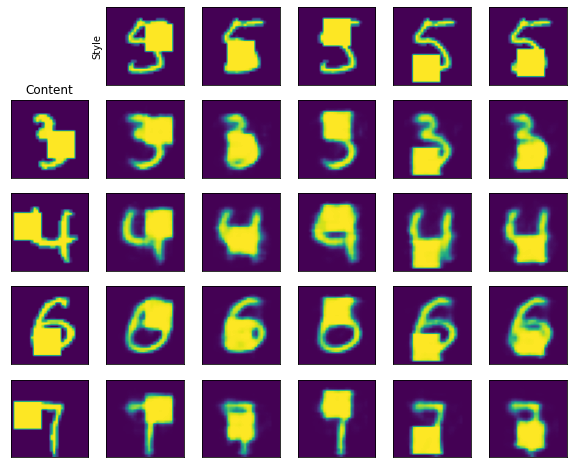

	mean loss    = 499.009
	mse          = 3.361e+02
	KL           = 2.951e+02
	KL           = 3.584e+01
	dec_var      = 1.000e+00
epoch = 47.67s
Start of epoch 41
	mean loss    = 498.497
	mse          = 3.350e+02
	KL           = 2.951e+02
	KL           = 3.587e+01
	dec_var      = 1.000e+00
epoch = 44.99s
Start of epoch 42
	mean loss    = 497.879
	mse          = 3.337e+02
	KL           = 2.951e+02
	KL           = 3.592e+01
	dec_var      = 1.000e+00
epoch = 45.61s
Start of epoch 43
	mean loss    = 497.350
	mse          = 3.326e+02
	KL           = 2.951e+02
	KL           = 3.593e+01
	dec_var      = 1.000e+00
epoch = 45.71s
Start of epoch 44
	mean loss    = 496.889
	mse          = 3.315e+02
	KL           = 2.952e+02
	KL           = 3.595e+01
	dec_var      = 1.000e+00
epoch = 45.59s
Start of epoch 45
=== TRN ===


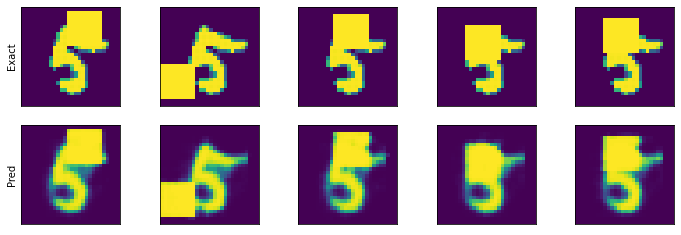

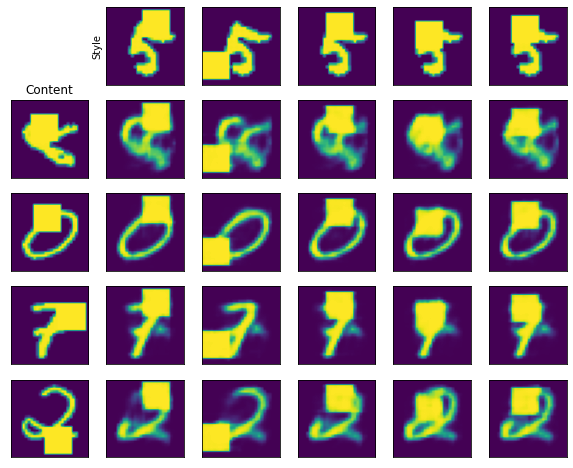

	mean loss    = 496.445
	mse          = 3.304e+02
	KL           = 2.953e+02
	KL           = 3.598e+01
	dec_var      = 1.000e+00
epoch = 47.22s
Start of epoch 46
	mean loss    = 495.931
	mse          = 3.295e+02
	KL           = 2.952e+02
	KL           = 3.601e+01
	dec_var      = 1.000e+00
epoch = 45.82s
Start of epoch 47
	mean loss    = 495.418
	mse          = 3.283e+02
	KL           = 2.952e+02
	KL           = 3.602e+01
	dec_var      = 1.000e+00
epoch = 44.91s
Start of epoch 48
	mean loss    = 495.002
	mse          = 3.275e+02
	KL           = 2.952e+02
	KL           = 3.604e+01
	dec_var      = 1.000e+00
epoch = 45.26s
Start of epoch 49
	mean loss    = 494.561
	mse          = 3.265e+02
	KL           = 2.953e+02
	KL           = 3.606e+01
	dec_var      = 1.000e+00
epoch = 45.56s
Start of epoch 50
=== TRN ===


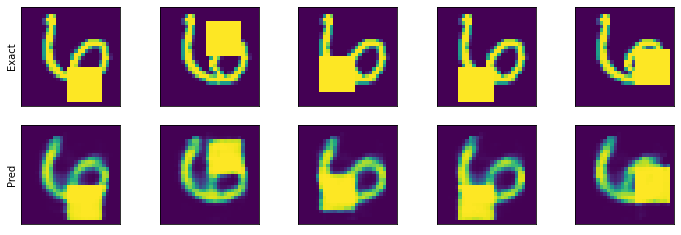

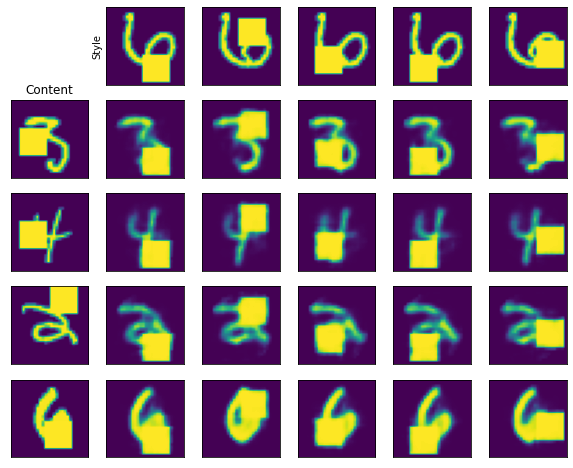

	mean loss    = 494.253
	mse          = 3.259e+02
	KL           = 2.952e+02
	KL           = 3.610e+01
	dec_var      = 1.000e+00
epoch = 47.48s
Start of epoch 51
	mean loss    = 493.860
	mse          = 3.249e+02
	KL           = 2.953e+02
	KL           = 3.610e+01
	dec_var      = 1.000e+00
epoch = 45.33s
Start of epoch 52
	mean loss    = 493.430
	mse          = 3.241e+02
	KL           = 2.953e+02
	KL           = 3.613e+01
	dec_var      = 1.000e+00
epoch = 45.85s
Start of epoch 53
	mean loss    = 493.046
	mse          = 3.232e+02
	KL           = 2.953e+02
	KL           = 3.616e+01
	dec_var      = 1.000e+00
epoch = 46.01s
Start of epoch 54
	mean loss    = 492.672
	mse          = 3.225e+02
	KL           = 2.953e+02
	KL           = 3.616e+01
	dec_var      = 1.000e+00
epoch = 46.07s
Start of epoch 55
=== TRN ===


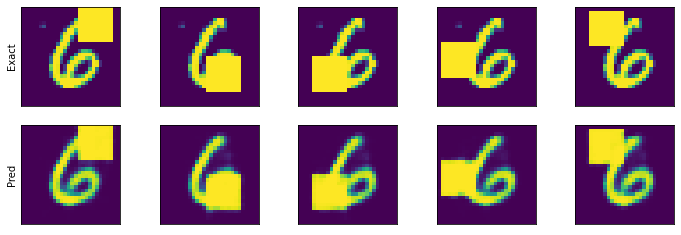

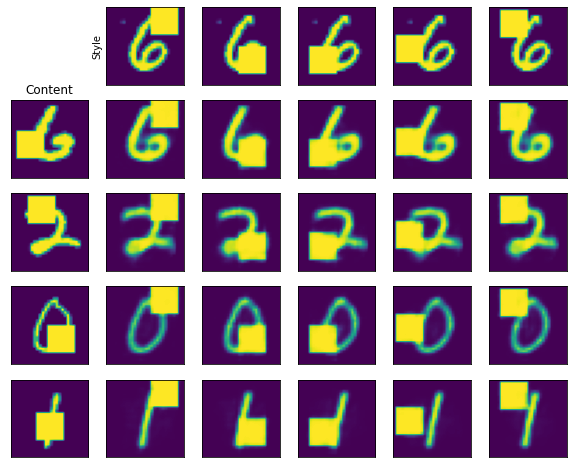

	mean loss    = 492.491
	mse          = 3.219e+02
	KL           = 2.954e+02
	KL           = 3.617e+01
	dec_var      = 1.000e+00
epoch = 47.50s
Start of epoch 56
	mean loss    = 492.107
	mse          = 3.210e+02
	KL           = 2.954e+02
	KL           = 3.619e+01
	dec_var      = 1.000e+00
epoch = 45.54s
Start of epoch 57
	mean loss    = 491.854
	mse          = 3.205e+02
	KL           = 2.954e+02
	KL           = 3.619e+01
	dec_var      = 1.000e+00
epoch = 46.10s
Start of epoch 58
	mean loss    = 491.524
	mse          = 3.198e+02
	KL           = 2.954e+02
	KL           = 3.623e+01
	dec_var      = 1.000e+00
epoch = 45.37s
Start of epoch 59
	mean loss    = 491.198
	mse          = 3.192e+02
	KL           = 2.954e+02
	KL           = 3.622e+01
	dec_var      = 1.000e+00
epoch = 45.69s
Start of epoch 60
=== TRN ===


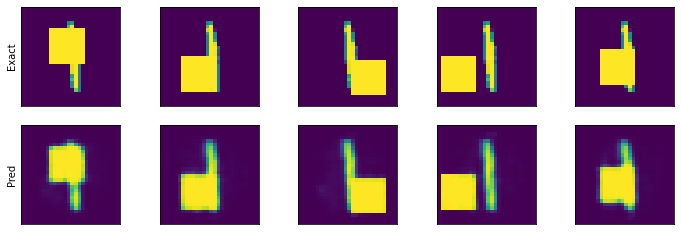

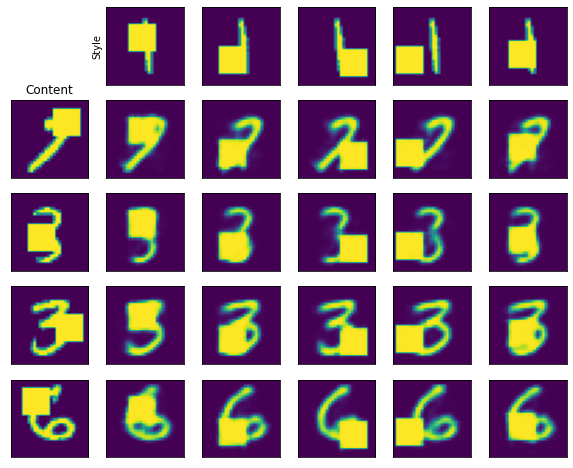

	mean loss    = 490.935
	mse          = 3.184e+02
	KL           = 2.955e+02
	KL           = 3.626e+01
	dec_var      = 1.000e+00
epoch = 48.03s
Start of epoch 61
	mean loss    = 490.659
	mse          = 3.179e+02
	KL           = 2.955e+02
	KL           = 3.626e+01
	dec_var      = 1.000e+00
epoch = 44.90s
Start of epoch 62
	mean loss    = 490.337
	mse          = 3.172e+02
	KL           = 2.955e+02
	KL           = 3.627e+01
	dec_var      = 1.000e+00
epoch = 45.71s
Start of epoch 63
	mean loss    = 490.188
	mse          = 3.168e+02
	KL           = 2.955e+02
	KL           = 3.629e+01
	dec_var      = 1.000e+00
epoch = 45.40s
Start of epoch 64
	mean loss    = 489.872
	mse          = 3.162e+02
	KL           = 2.955e+02
	KL           = 3.628e+01
	dec_var      = 1.000e+00
epoch = 45.30s
Start of epoch 65
=== TRN ===


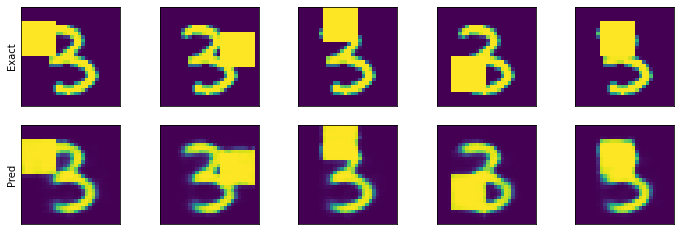

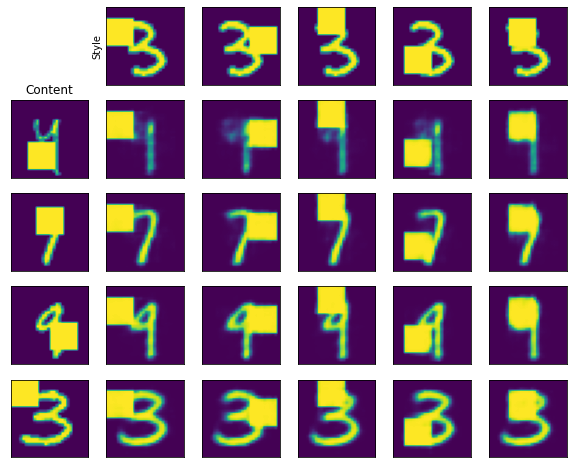

	mean loss    = 489.513
	mse          = 3.156e+02
	KL           = 2.954e+02
	KL           = 3.631e+01
	dec_var      = 1.000e+00
epoch = 47.42s
Start of epoch 66
	mean loss    = 489.291
	mse          = 3.150e+02
	KL           = 2.955e+02
	KL           = 3.632e+01
	dec_var      = 1.000e+00
epoch = 45.42s
Start of epoch 67
	mean loss    = 489.160
	mse          = 3.146e+02
	KL           = 2.955e+02
	KL           = 3.635e+01
	dec_var      = 1.000e+00
epoch = 45.89s
Start of epoch 68
	mean loss    = 488.991
	mse          = 3.142e+02
	KL           = 2.956e+02
	KL           = 3.634e+01
	dec_var      = 1.000e+00
epoch = 46.44s
Start of epoch 69
	mean loss    = 488.723
	mse          = 3.137e+02
	KL           = 2.955e+02
	KL           = 3.636e+01
	dec_var      = 1.000e+00
epoch = 45.31s
Start of epoch 70
=== TRN ===


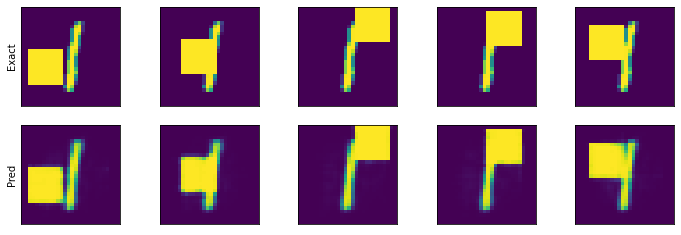

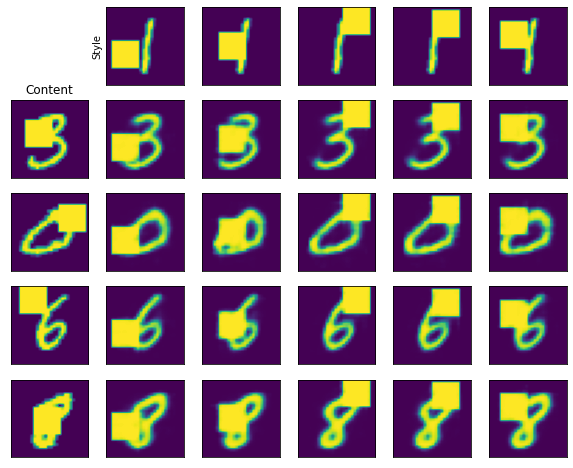

	mean loss    = 488.477
	mse          = 3.131e+02
	KL           = 2.956e+02
	KL           = 3.636e+01
	dec_var      = 1.000e+00
epoch = 46.83s
Start of epoch 71
	mean loss    = 488.240
	mse          = 3.127e+02
	KL           = 2.955e+02
	KL           = 3.636e+01
	dec_var      = 1.000e+00
epoch = 46.82s
Start of epoch 72
	mean loss    = 488.148
	mse          = 3.124e+02
	KL           = 2.956e+02
	KL           = 3.639e+01
	dec_var      = 1.000e+00
epoch = 46.09s
Start of epoch 73
	mean loss    = 487.923
	mse          = 3.118e+02
	KL           = 2.956e+02
	KL           = 3.641e+01
	dec_var      = 1.000e+00
epoch = 45.59s
Start of epoch 74
	mean loss    = 487.680
	mse          = 3.114e+02
	KL           = 2.956e+02
	KL           = 3.640e+01
	dec_var      = 1.000e+00
epoch = 45.07s
Start of epoch 75
=== TRN ===


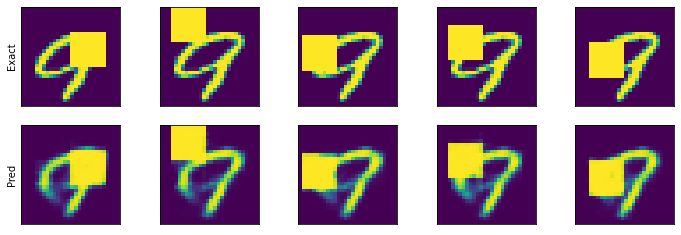

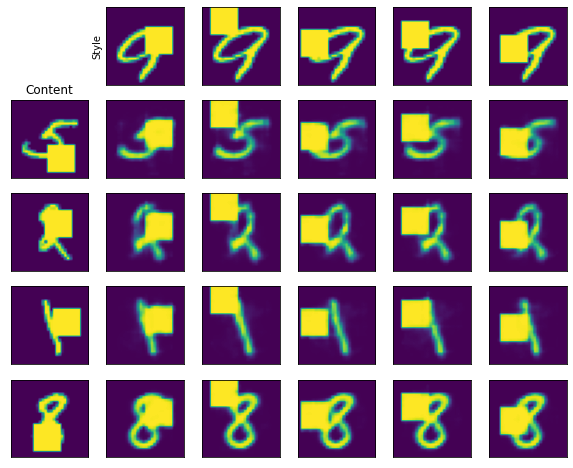

	mean loss    = 487.596
	mse          = 3.112e+02
	KL           = 2.956e+02
	KL           = 3.642e+01
	dec_var      = 1.000e+00
epoch = 48.12s
Start of epoch 76
	mean loss    = 487.375
	mse          = 3.107e+02
	KL           = 2.956e+02
	KL           = 3.643e+01
	dec_var      = 1.000e+00
epoch = 46.45s
Start of epoch 77
	mean loss    = 487.139
	mse          = 3.103e+02
	KL           = 2.956e+02
	KL           = 3.643e+01
	dec_var      = 1.000e+00
epoch = 46.82s
Start of epoch 78
	mean loss    = 487.064
	mse          = 3.100e+02
	KL           = 2.956e+02
	KL           = 3.645e+01
	dec_var      = 1.000e+00
epoch = 46.03s
Start of epoch 79
	mean loss    = 486.753
	mse          = 3.094e+02
	KL           = 2.956e+02
	KL           = 3.644e+01
	dec_var      = 1.000e+00
epoch = 46.39s
Start of epoch 80
=== TRN ===


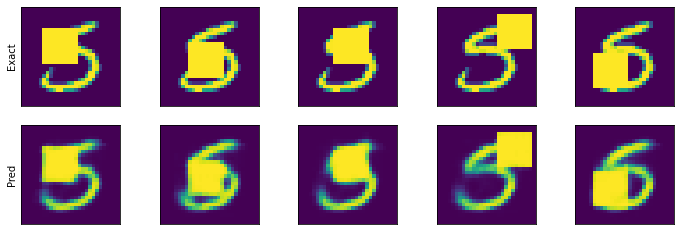

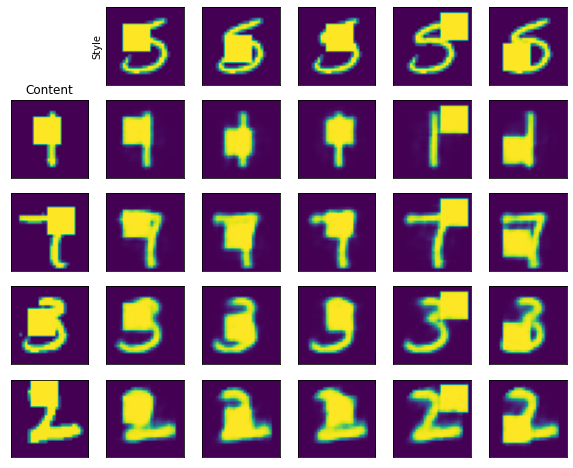

	mean loss    = 486.678
	mse          = 3.092e+02
	KL           = 2.956e+02
	KL           = 3.646e+01
	dec_var      = 1.000e+00
epoch = 48.31s
Start of epoch 81
	mean loss    = 486.577
	mse          = 3.089e+02
	KL           = 2.957e+02
	KL           = 3.646e+01
	dec_var      = 1.000e+00
epoch = 48.52s
Start of epoch 82
	mean loss    = 486.467
	mse          = 3.085e+02
	KL           = 2.957e+02
	KL           = 3.647e+01
	dec_var      = 1.000e+00
epoch = 48.55s
Start of epoch 83
	mean loss    = 486.256
	mse          = 3.081e+02
	KL           = 2.957e+02
	KL           = 3.648e+01
	dec_var      = 1.000e+00
epoch = 47.38s
Start of epoch 84
	mean loss    = 486.007
	mse          = 3.077e+02
	KL           = 2.957e+02
	KL           = 3.647e+01
	dec_var      = 1.000e+00
epoch = 48.80s
Start of epoch 85
=== TRN ===


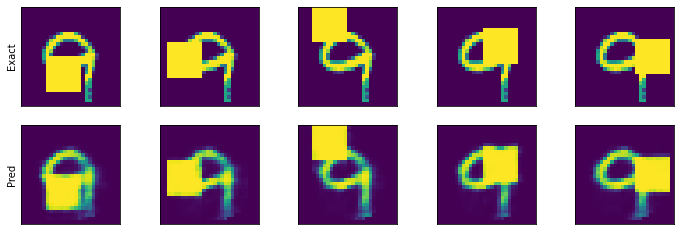

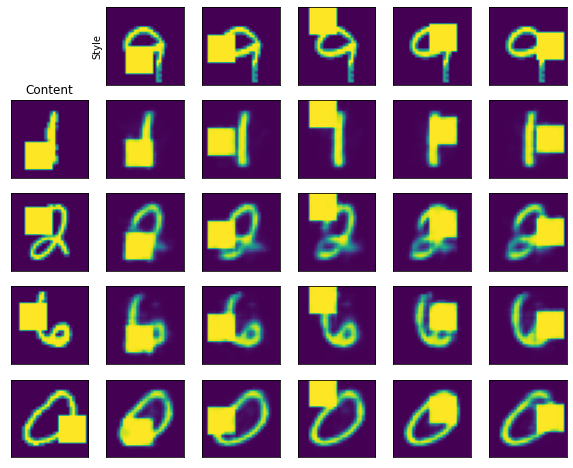

	mean loss    = 485.861
	mse          = 3.076e+02
	KL           = 2.956e+02
	KL           = 3.649e+01
	dec_var      = 1.000e+00
epoch = 50.25s
Start of epoch 86
	mean loss    = 485.904
	mse          = 3.072e+02
	KL           = 2.958e+02
	KL           = 3.650e+01
	dec_var      = 1.000e+00
epoch = 48.69s
Start of epoch 87
	mean loss    = 485.678
	mse          = 3.070e+02
	KL           = 2.957e+02
	KL           = 3.651e+01
	dec_var      = 1.000e+00
epoch = 47.50s
Start of epoch 88
	mean loss    = 485.544
	mse          = 3.067e+02
	KL           = 2.957e+02
	KL           = 3.651e+01
	dec_var      = 1.000e+00
epoch = 48.74s
Start of epoch 89
	mean loss    = 485.323
	mse          = 3.063e+02
	KL           = 2.957e+02
	KL           = 3.651e+01
	dec_var      = 1.000e+00
epoch = 47.93s
Start of epoch 90
=== TRN ===


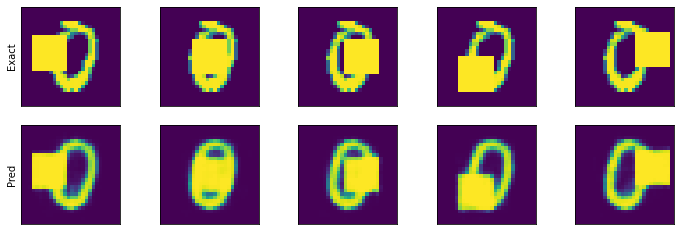

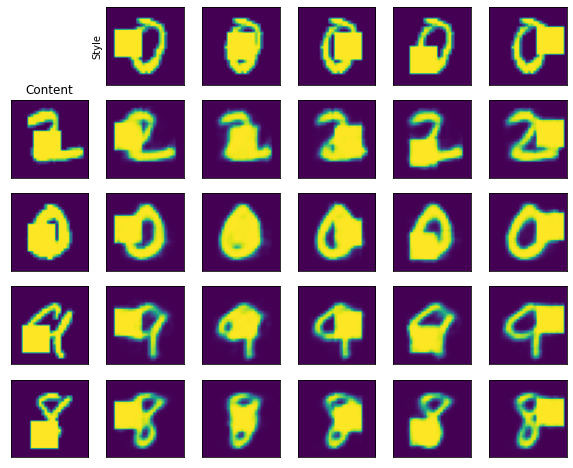

	mean loss    = 485.259
	mse          = 3.060e+02
	KL           = 2.957e+02
	KL           = 3.653e+01
	dec_var      = 1.000e+00
epoch = 49.75s
Start of epoch 91
	mean loss    = 485.267
	mse          = 3.059e+02
	KL           = 2.958e+02
	KL           = 3.653e+01
	dec_var      = 1.000e+00
epoch = 47.93s
Start of epoch 92
	mean loss    = 484.964
	mse          = 3.054e+02
	KL           = 2.957e+02
	KL           = 3.654e+01
	dec_var      = 1.000e+00
epoch = 47.41s
Start of epoch 93
	mean loss    = 484.787
	mse          = 3.051e+02
	KL           = 2.957e+02
	KL           = 3.653e+01
	dec_var      = 1.000e+00
epoch = 47.45s
Start of epoch 94
	mean loss    = 484.757
	mse          = 3.052e+02
	KL           = 2.956e+02
	KL           = 3.653e+01
	dec_var      = 1.000e+00
epoch = 46.91s
Start of epoch 95
=== TRN ===


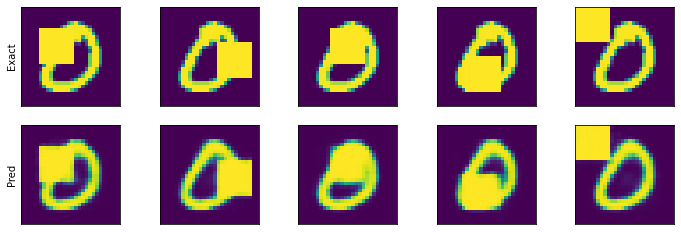

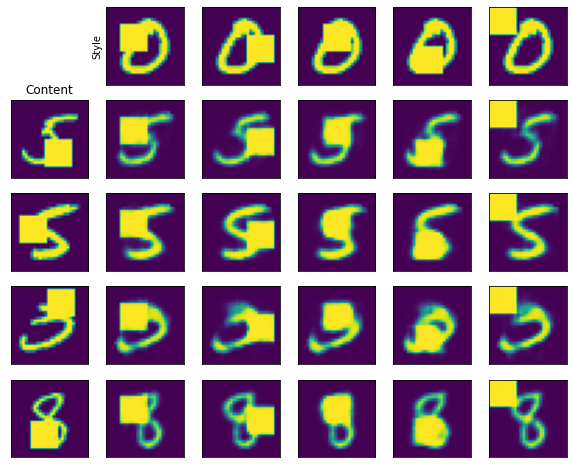

	mean loss    = 484.694
	mse          = 3.047e+02
	KL           = 2.958e+02
	KL           = 3.655e+01
	dec_var      = 1.000e+00
epoch = 48.61s
Start of epoch 96
	mean loss    = 484.479
	mse          = 3.044e+02
	KL           = 2.957e+02
	KL           = 3.657e+01
	dec_var      = 1.000e+00
epoch = 46.26s
Start of epoch 97
	mean loss    = 484.501
	mse          = 3.044e+02
	KL           = 2.957e+02
	KL           = 3.657e+01
	dec_var      = 1.000e+00
epoch = 45.71s
Start of epoch 98
	mean loss    = 484.440
	mse          = 3.042e+02
	KL           = 2.958e+02
	KL           = 3.656e+01
	dec_var      = 1.000e+00
epoch = 47.40s
Start of epoch 99
	mean loss    = 484.140
	mse          = 3.038e+02
	KL           = 2.957e+02
	KL           = 3.657e+01
	dec_var      = 1.000e+00
epoch = 46.97s
Start of epoch 100
=== TRN ===


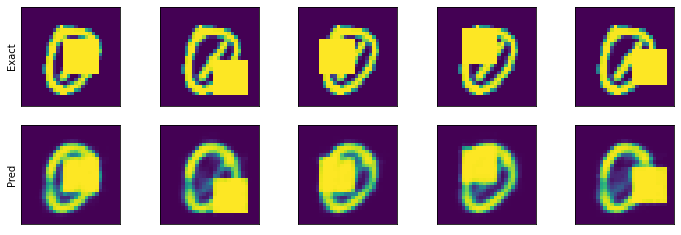

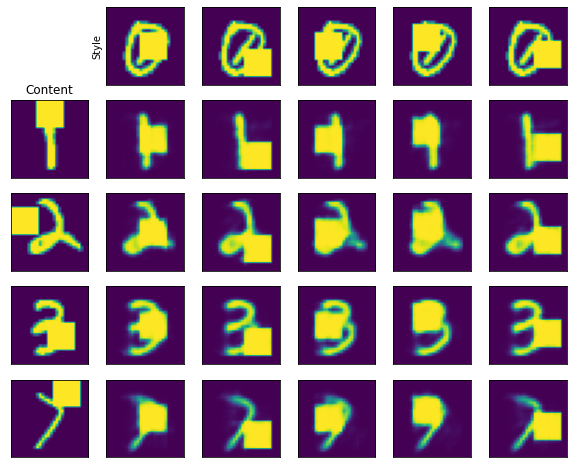

	mean loss    = 484.100
	mse          = 3.036e+02
	KL           = 2.957e+02
	KL           = 3.657e+01
	dec_var      = 1.000e+00
epoch = 49.48s


In [7]:
# Iterate over epochs.
num_epochs = 101

for epoch in range(num_epochs):
#     display.clear_output(wait=False)
    print('===================', flush=True)
    print('Start of epoch %d' % (epoch,))
    start_time = time.perf_counter()
         
    for step, trn_batch in enumerate(trn_dist_dataset):
        _ = distributed_train_step(trn_batch)
            
    if epoch % 5 == 0:
        print('=== TRN ===')
#         if strategy.num_replicas_in_sync > 1:
#             # grab only batch assigned to first GPU
#             trn_batch = [x.values[0].numpy() for x in trn_batch]
#         else:
#             trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = trn_batch.numpy()

        trn_batch = trn_batch.values[0].numpy()
        """ plot decoding of replicates """
        pred = gvae.encode_decode(trn_batch)
#         se = (pred - trn_batch[0])**2 # squared error
        
        pred = pred.numpy()
        
        plt.figure(figsize=(12,4), facecolor='w')
        num_instance_plot = min([5, NUM_INSTANCES])
        for kk in np.arange(num_instance_plot):
            plt.subplot(2, num_instance_plot, kk+1)
            plt.imshow(trn_batch[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Exact')
                    
            plt.subplot(2, num_instance_plot, num_instance_plot+kk+1)
            plt.imshow(pred[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Pred')
            
        plt.show()
        
        """ plot styling of replicates """
        nsplot = 5 # number of style plots

        content_code = gvae.content_encode(trn_batch).numpy()
        style_code = gvae.style_encode(trn_batch).numpy()
        
        plt.figure(figsize=(10,10), facecolor='w')
        for jj in np.arange(nsplot):
            styled_mean = gvae.style_decode(content_code[[jj],:,:], style_code[[0],:,:])
            styled_mean = styled_mean.numpy()
            for kk in np.arange(nsplot):
                if jj == 0:
                    # plot the style of each instance inside the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, kk+2)
                    plt.imshow(trn_batch[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    if kk==0:
                        plt.ylabel('Style')
                else:
                    if kk==0:
                        # plot an instance to show the "content"
                        plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+1)
                        plt.imshow(trn_batch[jj,0,:].reshape(28,28))
                        plt.xticks([]); plt.yticks([]);
                        if jj == 1:
                            plt.title('Content')

                    # style the jth bag with styles from the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+2)
                    plt.imshow(styled_mean[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    
        plt.show()
    
    print('\tmean loss    = %.3f' % trn_loss_metric.result().numpy())
    print('\tmse          = %.3e' % trn_mse_metric.result().numpy())
    print('\tKL           = %.3e' % trn_sty_KL_metric.result().numpy())
    print('\tKL           = %.3e' % trn_cnt_KL_metric.result().numpy())
    print('\tdec_var      = %.3e' % gvae.decoder.dec_var.numpy())
    trn_loss_metric.reset_states()
    trn_mse_metric.reset_states()
    trn_sty_KL_metric.reset_states()
    trn_cnt_KL_metric.reset_states()
    
    print('epoch = %.2fs' % (time.perf_counter()-start_time))

In [8]:
# # https://www.tensorflow.org/guide/keras/save_and_serialize#hdf5_format
gvae.save_weights('gvae-masked-mnist.h5')